# ENSF 544 Data Science for Software Engineers
**Assignment 2** - 100 marks

**Due:** October 2th, 9:00 AM.


**IMPORTANT NOTE: each task must be implemented as asked, even if there are other easier or better solutions.**

**How to deliver:**
Edit this file and write your solutions in sections specified with `# Your solution`. Test your code and when you are done, submit this notebook as an `.ipynb` file to D2L dropbox.

**Sahar Khazali** 

## Problem 1 - Most popular games (20 points)
In this assigment we want to do some basic data analysis on the most popular games on Metacritics for PlayStation 4.
We do this in steps: first we take the list of most popular games then we gather more information on each game from the game's page.
These info are then stored in pandas dataframes. Next we need to combine the information from these two tables, using pandas `merge` method.
The resulting merged table might give us some insight on why some games get more popular. Let's try and see what we can get!

Complete the `get_page_html` function below so that it gets the HTML content of any given url. We get the HTML content and store it in a variable just once, because:
1. Downloading the web page content takes some time. While you're writing the html parser code you need to run and test your code many many times. If you download the whole page everytime you want to test the parser, these download times add up to significantly slow you down.
2. Making a lot of requests to the same page of a website in a short period of time might make the firewall suspicious of an attack and block your IP address

In [180]:
from IPython.core.display import display
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from bs4.element import Tag
import re
from datetime import datetime, timedelta
import time
from tqdm import tqdm
import matplotlib.colors


C:\Users\godwi\AppData\Local\Temp\ipykernel_13648\2174299130.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [181]:
#!conda install requests
page_url = 'https://www.metacritic.com/browse/games/score/metascore/all/ps4/filtered?view=detailed'

# Necessary UA. If this is not set, page returns 403
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.54 Safari/537.36'}

def get_page_html(url):
  response = requests.get(page_url, headers = headers)
  return response.text

top_games_html = get_page_html(page_url)
print(top_games_html)

<!DOCTYPE html>
<html xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://ogp.me/ns/fb#">
<head>
            <title>Best PlayStation 4 Video Games of All Time - Metacritic</title>
        
    <meta http-equiv="content-type" content="text/html; charset=UTF-8">

    
    <meta name="description" content="See how well critics are rating the Best PlayStation 4 Video Games of All Time">

    
    
    
    <meta name="application-name" content="Metacritic">
    <meta name="msapplication-TileColor" content="#000000">
    <meta name="msapplication-TileImage" content="/images/win8tile/76bf1426-2886-4b87-ae1c-06424b6bb8a2.png">

        
    <meta name="facebook-domain-verification" content="618k3mbeki8tar7u6wvrum5lxs5cka" />

    
    
                                        <meta property="og:title" content="Best PlayStation 4 Video Games of All Time">
                                                <meta property="og:type" content="website">
                                    

Parse the HTML content above using Beautiful Soup to extract these data:

* Name of the game (`name`: str)
* link to its details page (`details_url`: str)

links are relative so you need to append them to the base url.

In [182]:
base = 'https://www.metacritic.com'

def get_top_games(html_content):
    
    soup = BeautifulSoup(html_content, 'html.parser')
    rows = soup.select('div.browse_list_wrapper > table > tr:not(.spacer)')
    raw = []
    for row in rows:
        rank = int(re.search('\d+', row.select_one('span[class="title numbered"]').get_text()).group(0))

        # names are contained within <h3>
        name = re.search('.+', row.select_one("h3").get_text()).group(0)

        # links are contained within <a href = ...>
        details_url = base + row.select_one('a')['href']
            
        release_date = row.select_one('div.clamp-details > span').get_text().strip()
        release_date = datetime.strptime(release_date, '%B %d, %Y')
        score = int(row.select_one('div.metascore_w').get_text().strip())
        raw.append((rank, name, release_date, score, details_url))
        return pd.DataFrame(raw, columns=('rank', 'name', 'release_date', 'score', 'details_url')).set_index('rank')

top_games = get_top_games(top_games_html)
print(top_games)
#top_games  # Rank must be the index, the rows should match the webpage


                       name release_date  score  \
rank                                              
1     Red Dead Redemption 2   2018-10-26     97   

                                            details_url  
rank                                                     
1     https://www.metacritic.com/game/playstation-4/...  


## Problem 2 - Numpy and Pandas (50points)

For the second problem, there is a dataset containing booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things. First run the code below to be familiar with data and columns(feel free to explore dataset) then answer the questions.

In [183]:
dataset = pd.read_csv("hotel_booking_data.csv")
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


**a) What are the top 5 most common country codes in the dataset?**

In [184]:
# sorts the dataset by country (top to bottom), then extracts the first 5 rows (i.e. the top 5 results)

common_five_codes = dataset['country'].value_counts().head(5)

print(common_five_codes) # returns PRT, GBR, FRA, ESP, DEU

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
Name: country, dtype: int64


**b) What is the name of the person who paid the highest ADR (average daily rate)? How much was their ADR?**

In [185]:
# sorts the dataset by ADR (top to bottom), then extracts the 1st row (i.e. the top result)

top_ADR = dataset.sort_values(by = ['adr'], ascending = False).head(1)

print(top_ADR[['name', 'adr']]) # returns Daniel Walter with ADR = 5400


                name    adr
48515  Daniel Walter 5400.0


**c) What is the mean adr across all the hotel stays in the dataset?**

In [186]:
# pretty obvious

mean_ADR = dataset['adr'].mean()

print(mean_ADR) # returns 101.83

101.83112153446686


**d) What are the names of the people who had booked the most number children and babies for their stay?**

In [187]:
# combine children and babies; note these values in a new column

dataset['kids'] = dataset['children'] + dataset['babies']

# sort the results in descending order
# let's get the top 10 people (number arbitrarily chosen)

sorted_kids = dataset.sort_values(by = ['kids'], ascending = False).head(10)

print(sorted_kids[['name', 'kids']]) # prints Jamie Ramirez (10), then Nicholas Parker (10), then Marc Robinson (9)



                     name  kids
328         Jamie Ramirez  10.0
46619     Nicholas Parker  10.0
78656       Marc Robinson   9.0
19718   Mr. Jeffrey Cross   3.0
107837      Albert French   3.0
24409   Lindsay Rodriguez   3.0
90790       Nathaniel Kim   3.0
95227          Nancy Cole   3.0
106216    Krystal Trevino   3.0
27246         Faith Smith   3.0


**e)What are the top 5 most common last name in the dataset? Bonus: Can you figure this out in one line of pandas code? (For simplicity treat the a title such as MD as a last name, for example Caroline Conley MD can be said to have the last name MD)**

In [188]:
# split the names and get the last part (which is the last name); note these values in a new column

dataset['last_name'] = dataset['name'].str.split().str[-1]

# sorts the dataset by last name (top to bottom), then extracts the first 5 rows (i.e. the top 5 results)

top_last_name = dataset['last_name'].value_counts().head(5)

print(top_last_name) # returns Smith, Johnson, Williams, Jones, then Brown

Smith       2503
Johnson     1990
Williams    1618
Jones       1434
Brown       1423
Name: last_name, dtype: int64


# Problem 3 - Visualizing and Analysing (30 points)

based on the Dataset you have, try to use **4 different plots** to visualize data in depth (notice the type of plots are up to you).</bbr>

**you can use this link to learn more about visualization and how you can plot the difference between columns in this dataset. https://towardsdatascience.com/data-visualization-for-machine-learning-and-data-science-a45178970be7**
   
<p>
    <b> Examples:</b>
<br>
a) Cancelled bookings in different hotels <br>
b) THe relationship between 'arrival_date_month' and 'arrival_date_year'<br>
c) Average room price per night in different hotels<br>
d) Type of meal booked with pie plot    
</p>

C:\Users\godwi\AppData\Local\Temp\ipykernel_13648\2162379417.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r_hotel = bookings[dataset['hotel'] == 'Resort Hotel']
C:\Users\godwi\AppData\Local\Temp\ipykernel_13648\2162379417.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_hotel = bookings[dataset['hotel'] == 'City Hotel']


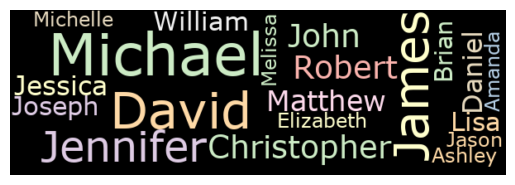

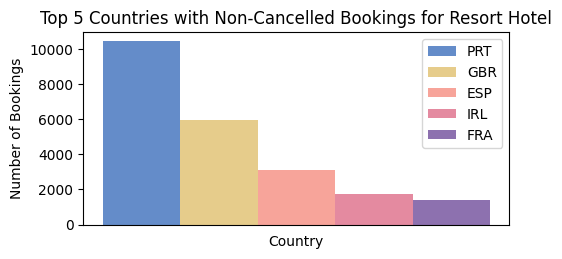

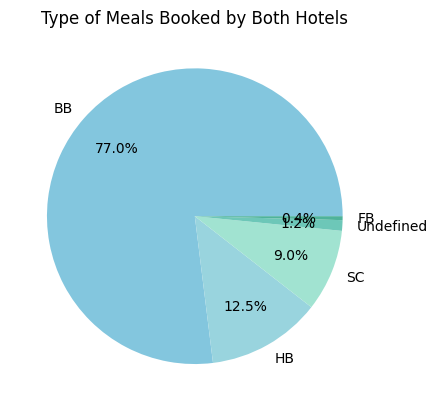

<AxesSubplot: xlabel='Year', ylabel='Month'>

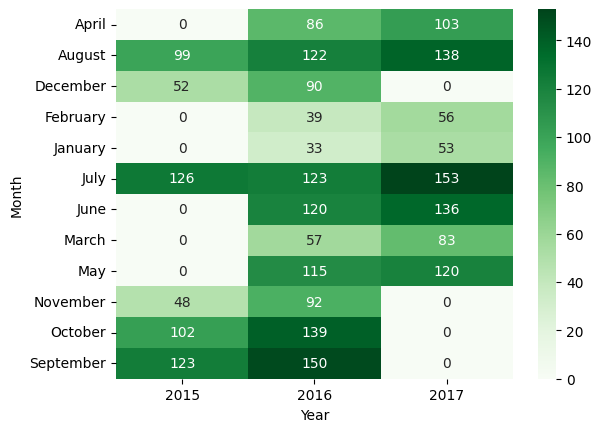

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt

### 1) Most Common First Names of Bookers - could be useful for hotels to design merchandise around common names (like those keychains)

from os import path
from wordcloud import WordCloud

# Extract first names only, then convert this to text by making a singular string made of these strings separated by spaces (' ')
dataset['first_name'] = dataset['name'].str.split().str[0]
first_name_as_text = ' '.join(dataset['first_name'])

# These are keywords that we'll use to ignore salutations in the wordcloud. Called by stopwords (the word cloud)
stopwords = ['Mr', 'Dr', 'Mrs', 'Ms']

# Make the wordcloud. Settings are pretty self-explanatory; relative scaling incorporates frequency, and colormap uses Pastel1 for the font colors used from mathplotlib's colormaps
word_cloud = WordCloud(font_path = 'verdana', background_color = "black", max_font_size = 70, max_words = 20, width = 600, stopwords = stopwords, relative_scaling = 0.5, colormap = 'Pastel1')
wordcloud = word_cloud.generate(first_name_as_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#---------------------------#

### 2) Top 5 Booked Countries for Each Hotel

# only get bookings that weren't cancelled
bookings = dataset[dataset['reservation_status'] != "Canceled"]

# only get bookings from each hotel (Resort Hotel & City Hotel) respectively
r_hotel = bookings[dataset['hotel'] == 'Resort Hotel']
c_hotel = bookings[dataset['hotel'] == 'City Hotel']

# only get the top 5 countries for each hotel
top5_r_hotel = r_hotel['country'].value_counts().head(5)
top5_c_hotel = c_hotel['country'].value_counts().head(5)

# get country names only
# note that we get values via top5_x_hotel[index_to_get_from]
top5_r_names = top5_r_hotel.index.tolist()
top5_c_names = top5_c_hotel.index.tolist()

# vars to determine sizes of bars
a = np.arange(1)
w = 0.05

# initialize the plot
fig, ax = plt.subplots(figsize = (5.5,2.5), edgecolor = 'k')

# make 5 bars to contain each value of the top country values
p1 = ax.bar(a - 2 * w, top5_r_hotel[0], w, color ='#648CC9')
p2 = ax.bar(a - w, top5_r_hotel[1], w, color ='#E6CC8B')
p3 = ax.bar(a, top5_r_hotel[2], w, color ='#F7A49A')
p4 = ax.bar(a + w, top5_r_hotel[3], w, color ='#E48AA0')
p5 = ax.bar(a + 2 * w, top5_r_hotel[4], w, color ='#8D71AF')

# don't include x-axis title/axes
ax.set_xticks(([]))

# create legend using country names
ax.legend((top5_r_names[0:5]))

# create title and axes names
ax.set_title('Top 5 Countries with Non-Cancelled Bookings for Resort Hotel')
plt.xlabel('Country')
plt.ylabel("Number of Bookings")
plt.show()


## Uncomment this code and comment the above code to create a graph for City Hotel instead

#fig, ax = plt.subplots(figsize = (5.5,2.5), edgecolor = 'k')

#p1 = ax2.bar(a - 2 * w, top5_c_hotel[0], w, color ='b')
#p2 = ax2.bar(a - w, top5_c_hotel[1], w, color ='g')
#p3 = ax2.bar(a, top5_c_hotel[2], w, color ='y')
#p4 = ax2.bar(a + w, top5_c_hotel[3], w, color ='b')
#p5 = ax2.bar(a + 2 * w, top5_c_hotel[4], w, color ='g')

#ax.set_xticks(a)
#ax.set_xticklabels((top5_c_names[0:5]))
#ax.set_title('Top 5 Countries with Non-Cancelled Bookings for City Hotel')
#plt.xlabel('Country)
#plt.ylabel("Number of Bookings")

### 3) Type of Meal Booked

# note counts of meals and the names of the meals
meals = bookings['meal'].value_counts()
meal_names = meals.index.tolist()

# create a pie chart using the given colors and the above variables
colors = ['#83C6DE', '#99D4DE', '#A1E3D1', '#6DC7B8', '#4FB39B']
explosion = (0, 0, 0, 0, 0)
plt.pie(meals[0:5], colors =colors,labels = meal_names[0:5], autopct = '%1.1f%%', pctdistance = 0.7, explode = explosion)
fig = plt.gcf()
plt.title('Type of Meals Booked by Both Hotels')
plt.show()

### 4) Heatmap of Bookings

import seaborn as sns

# this is used to show heatmap values as WHOLE NUMBERS and not wacky scientific notation (using aggfunc = mean will cause this)
pd.set_option('display.float_format', str)

# rename the columns then create a pivot table. we rename the columns for the heatmap
dataset = dataset.rename(columns = {'arrival_date_month': 'Month', 'arrival_date_year': 'Year'})
pivot = dataset.pivot_table(index="Month", columns="Year", values="lead_time", aggfunc="mean").fillna(0)

# round to nearest hundred (XXX)
pivot.round(3)

#make the heatmap
sns.heatmap(pivot, annot = True, fmt='.0f', cmap="Greens")
